In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/power_plant_energy_output_prediction_weekend_hackathon_13/CCPP_participants_Data.zip

--2020-07-26 12:57:16--  https://machinehack-be.s3.amazonaws.com/power_plant_energy_output_prediction_weekend_hackathon_13/CCPP_participants_Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.80
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804794 (786K) [application/zip]
Saving to: ‘CCPP_participants_Data.zip.1’

CCPP_participants_D 100%[===================>] 785.93K  1.17MB/s    in 0.7s    

2020-07-26 12:57:17 (1.17 MB/s) - ‘CCPP_participants_Data.zip.1’ saved [804794/804794]



In [ ]:
!unzip CCPP_participants_Data.zip

Archive:  CCPP_participants_Data.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: __MACOSX/._sample_submission.csv  
  inflating: Test.csv                
  inflating: __MACOSX/._Test.csv     
  inflating: Train.csv               
  inflating: __MACOSX/._Train.csv    


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [ ]:
train.tail(5)

,AT,V,AP,RH,PE
9563,4.44,38.44,1016.14,75.35,499.615488
9564,18.18,67.71,1004.50,87.26,461.130122
9565,10.96,45.01,1017.97,95.82,481.245635
9566,8.70,36.24,1013.34,89.50,490.928341
9567,27.97,58.84,1002.25,57.88,457.630310


In [ ]:
test.head(5)

,AT,V,AP,RH
0,16.98,53.16,1013.95,82.80
1,9.60,41.03,1021.01,69.03
2,6.11,38.68,1017.53,79.23
3,12.34,43.22,1009.28,78.23
4,27.67,59.14,1016.51,61.20


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(AT    0
 V     0
 AP    0
 RH    0
 PE    0
 dtype: int64, AT    0
 V     0
 AP    0
 RH    0
 dtype: int64, (9568, 5), (38272, 4), AT    float64
 V     float64
 AP    float64
 RH    float64
 PE    float64
 dtype: object)

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df['mean_all']=(df['AT']+df['V']+df['AP']+df['RH'])/4
df['Ag_x']=(df['AT']*df['RH'])/df['AP']
df['Ag_y']=(df['AT']+df['RH'])/df['V']
df['Ag_z']=df['AP']/df['V']

In [ ]:
train = df[df['PE'].isnull()==False]
test = df[df['PE'].isnull()==True]
del test['PE']

In [ ]:
train_df=train
test_df=test

In [ ]:
X = train_df.drop(labels=['PE'], axis=1)
y = train_df['PE'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.05, random_state=201)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((9089, 4), (9089,), (479, 4), (479,))

In [ ]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 5000,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 1000
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_error(y_cv,y_pred_lgbm)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 2.57242
[200]	valid_0's rmse: 2.35537
[300]	valid_0's rmse: 2.25897
[400]	valid_0's rmse: 2.22041
[500]	valid_0's rmse: 2.20241
[600]	valid_0's rmse: 2.18253
[700]	valid_0's rmse: 2.17282
[800]	valid_0's rmse: 2.16884
[900]	valid_0's rmse: 2.17205
[1000]	valid_0's rmse: 2.17519
Early stopping, best iteration is:
[809]	valid_0's rmse: 2.16775
RMSLE: 2.1677523738240816


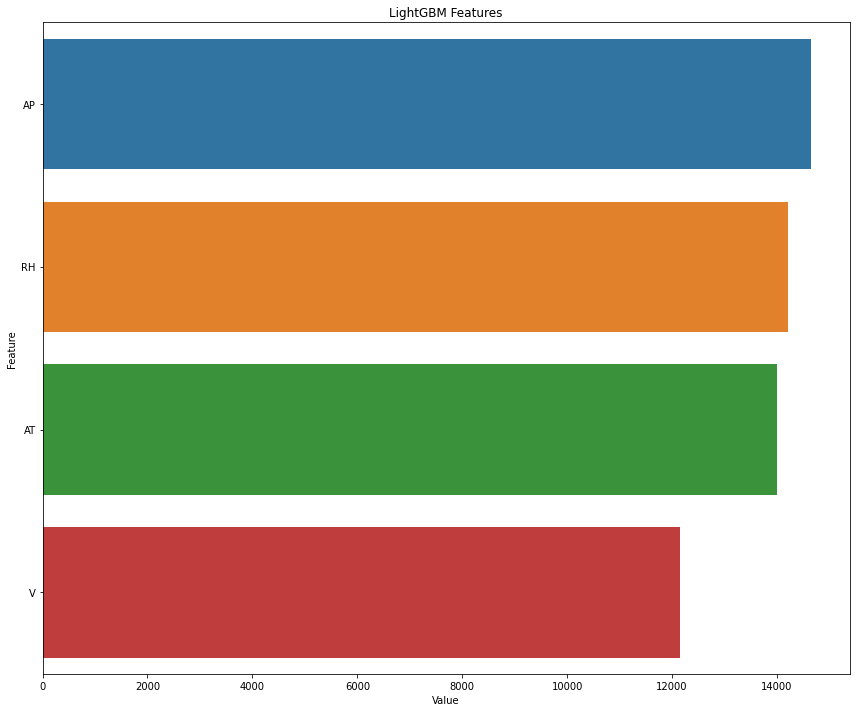

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=50, shuffle=True, random_state=201)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    #lgbm = LGBMRegressor(boosting='gbdt',learning_rate=0.07, n_estimators=3000, random_state=42, subsample=0.9)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_error(y_test,y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  1.820270914735864


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.111504787716103


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.177882529868912


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.4291058652150586


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.0804825323090474


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.722731988297223


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  3.1757467401785173


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  3.594166515598384


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.099879060168945


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1305203232471706


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  3.9190985376087792


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.4249656732532836


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.2567841496090804


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3040854306903964


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  1.993331607007354


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.246694354459947


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  1.7960989298326184


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1075034837517155


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3805500184411947


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.2710723744337526


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1884607992092797


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.246759237790925


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1373293935647277


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3732705190082384


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  1.9387163942890508


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.2446445797497887


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.44927296319783


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1055268980972985


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  1.9533463041313994


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3150893375705306


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1144455018508137


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.178099156614176


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.2261486479620713


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.29322396312942


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.463236351340822


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.212841100411235


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.6930434570348334


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.0476046736322386


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.6324627490927437


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.20547088181502


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3701073059739364


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.0501932729380345


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.54056667491444


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.1000410749818905


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.4418553666717635


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.4280603175857327


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.3214974218815065


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.7239439992618077


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.131906421012646


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  2.4537755412769555


In [ ]:
np.mean(errlgb,0)

2.33246832244829

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([472.1615492 , 494.99959204, 493.89800559, ..., 472.44119709,
       445.78992698, 465.18426078])

In [ ]:
submission = pd.DataFrame({
        "PE":lgbm_final
    })
submission.to_csv('./MH_Hack_80.csv', index=False)
print(submission)

               PE
0      472.161549
1      494.999592
2      493.898006
3      480.439122
4      445.714905
...           ...
38267  475.600499
38268  447.252430
38269  472.441197
38270  445.789927
38271  465.184261

[38272 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('MH_Hack_80.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#GB

In [ ]:
X = train_df.drop(labels=['PE'], axis=1)
y = train_df['PE'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.2, n_estimators=1000, random_state=42, subsample=0.8,min_samples_split=100,min_samples_leaf=50,max_depth=8,max_features='sqrt')
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('RMSE', sqrt(mean_squared_error(y_cv,y_pred)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         194.6448          95.7040           12.83s
         2         131.2546          63.2355           12.10s
         3          90.0541          41.9760           11.92s
         4          63.5533          26.8275           11.85s
         5          46.5763          16.6525           11.84s
         6          34.7844          11.2950           11.79s
         7          27.4188           7.0263           11.81s
         8          22.2203           4.8734           11.82s
         9          18.3149           3.3035           11.80s
        10          16.1635           1.9644           11.82s
        20          10.5451           0.1167           12.13s
        30           9.4426           0.0042           12.00s
        40           8.7261           0.0130           11.91s
        50           8.5824          -0.0047           11.82s
        60           7.9289          -0.0084           11.74s
       

In [ ]:
Xtest = test_df

In [ ]:

from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    #gb = GradientBoostingRegressor(learning_rate=0.15, n_estimators=1500, random_state=42, subsample=0.8)
    gb = GradientBoostingRegressor(learning_rate=0.2, n_estimators=1000, random_state=42, subsample=0.8,min_samples_split=100,min_samples_leaf=50,max_depth=8,max_features='sqrt')
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('MSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test,y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

MSE 2.720521957155422
MSE 2.655996829964928
MSE 2.9442759755065664
MSE 2.860395773481964


In [ ]:
np.mean(errgb,0)

2.79529763402722

In [ ]:
gb_fib = np.mean(y_pred_totgb,0)
gb_fib

array([472.7055276 , 494.49449174, 494.58631365, ..., 471.94888953,
       448.39609601, 463.08399225])

In [ ]:
submission = pd.DataFrame({
        "PE": gb_fib
    })
submission.to_csv('./MH_gb_x0.csv', index=False)
print(submission)

               PE
0      472.705528
1      494.494492
2      494.586314
3      480.005518
4      446.489687
...           ...
38267  476.240059
38268  446.495427
38269  471.948890
38270  448.396096
38271  463.083992

[38272 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('MH_gb_x0.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>